In [1]:
# import data
import numpy as np
import json

with open('data/pyData/notch14Data_S.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
labels = data[1]


#with open('data/pyData/notch14Data_L.json') as f:
#    dataL= json.load(f)
#pxxL=np.array(dataL[0])
#labels['allWindows']['baseline'].extend(dataL[1]['allWindows']['baseline'])
#labels['allWindows']['stimOn'].extend(dataL[1]['allWindows']['stimOn'])
#labels['allWindows']['stimOff'].extend(dataL[1]['allWindows']['stimOff'])
#labels['allWindows']['subject'].extend(dataL[1]['allWindows']['subject'])

#with open('data/pyData/notch14Data_C.json') as f:
#    dataC= json.load(f)
#pxxC=np.array(dataC[0])
#labels['allWindows']['baseline'].extend(dataC[1]['allWindows']['baseline'])
#labels['allWindows']['stimOn'].extend(dataC[1]['allWindows']['stimOn'])
#labels['allWindows']['stimOff'].extend(dataC[1]['allWindows']['stimOff'])
#labels['allWindows']['subject'].extend(dataC[1]['allWindows']['subject'])

#pxx=np.concatenate((pxx,pxxL,pxxC), axis=2)
#print(pxx.shape)
#print(len(labels['allWindows']['subject']))
#print(labels)

In [2]:
#pxx = np.log(pxx)

# reshape nd array to matrix
#a, b, c = pxx.shape
#X = pxx.reshape(a*b, c).T

#sI = np.zeros((len(labels['allWindows']['subject']),1))
#LI = np.zeros((len(labels['allWindows']['subject']),1))
#CI = np.zeros((len(labels['allWindows']['subject']),1))
#for i in np.arange(0,len(labels['allWindows']['subject'])):
#    sI[i] = "s_" in labels['allWindows']['subject'][i]
#    LI[i] = "ls" in labels['allWindows']['subject'][i] or "lm" in labels['allWindows']['subject'][i]
#    CI[i] = "ae" in labels['allWindows']['subject'][i] or "hm" in labels['allWindows']['subject'][i]
    
#print(pxx)

In [3]:
# reshape nd array to matrix
a, b, c = pxx.shape
X = pxx.reshape(a*b, c).T

#sI = np.zeros((len(labels['allWindows']['subject']),1))
#LI = np.zeros((len(labels['allWindows']['subject']),1))
#CI = np.zeros((len(labels['allWindows']['subject']),1))
#for i in np.arange(0,len(labels['allWindows']['subject'])):
#    sI[i] = "s_" in labels['allWindows']['subject'][i]
#    LI[i] = "ls" in labels['allWindows']['subject'][i] or "lm" in labels['allWindows']['subject'][i]
#    CI[i] = "ae" in labels['allWindows']['subject'][i] or "hm" in labels['allWindows']['subject'][i]
    
#sX = pxx(:,sI)

# Train data on standard experiments: ['allWindows']['subject']=='Rat_
# stimON = 1 vs nonstim = 0 (baseline AND stimOFF)
y = np.array(labels['allWindows']['stimOn'])


# prestim (baseline) = 0 vs poststim = 1 (stimOFF OR stimON)
y2 = (np.array(labels['allWindows']['baseline'])-1)**2

In [4]:
# split train/test sets
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=1423)

#x2Train, x2Test, y2Train, y2Test = train_test_split(X[Z==1], y2[Z==1], test_size=0.3, random_state=1423)
#print(y2Test.shape, y2Train.shape)

In [5]:
from sklearn.decomposition import FastICA

C = 20;

# Compute ICA
ica = FastICA(n_components=C, max_iter=5000,tol=0.001)
scoresTrain = ica.fit_transform(xTrain)  # Reconstruct signals

factors = ica.mixing_  # Get estimated mixing matrix
factors = factors.reshape(a, b, C)

# Compute ICA
#ica2 = FastICA(n_components=C, max_iter=5000,tol=0.001)
#scoresTrain2 = ica2.fit_transform(x2Train)  # Reconstruct signals

#factors2 = ica2.mixing_  # Get estimated mixing matrix
#factors2 = factors2.reshape(a, b, C)

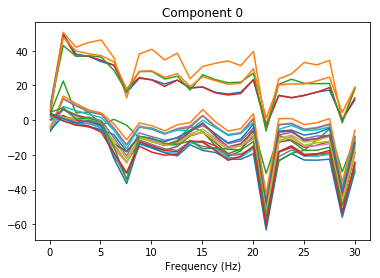

In [6]:
# plot a component
import matplotlib.pyplot as plt

component = 0

plt.figure()

plt.plot(labels['f'], factors[:,:,component])
plt.xlabel('Frequency (Hz)')
plt.title('Component ' + str(component))

plt.show()

#plt.figure()

#plt.plot(labels['f'], factors2[:,:,component])
#plt.xlabel('Frequency (Hz)')
#plt.title('Component ' + str(component))

#plt.show()

In [7]:
print(factors.shape)

(25, 24, 20)


In [8]:
# classify baseline
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

classifier = svm.SVC(kernel='linear', probability=True, class_weight='balanced')
classifier.fit(scoresTrain, yTrain)
trainAcc = classifier.score(scoresTrain, yTrain)

scoresTest = ica.transform(xTest)
testAcc = classifier.score(scoresTest, yTest)
print(testAcc, trainAcc)

#classifier2 = svm.SVC(kernel='linear')
#classifier2.fit(scoresTrain2, y2Train)
#trainAcc2 = classifier2.score(scoresTrain2, y2Train)

#scoresTest2 = ica2.transform(x2Test)
#testAcc2 = classifier2.score(scoresTest2, y2Test)
#print(testAcc2, trainAcc2)

0.684630738523 0.688445078459


In [9]:
# Compute ROC curve and ROC area for each class
yScore = classifier.fit(xTrain, yTrain).decision_function(xTest)
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(yTest, yScore)
roc_auc = auc(fpr, tpr)

#yScore2 = classifier2.fit(x2Train, y2Train).decision_function(x2Test)
#fpr2 = dict()
#tpr2 = dict()
#roc_auc2 = dict()
#fpr2, tpr2, _ = roc_curve(y2Test, yScore2)
#roc_auc2 = auc(fpr2, tpr2)

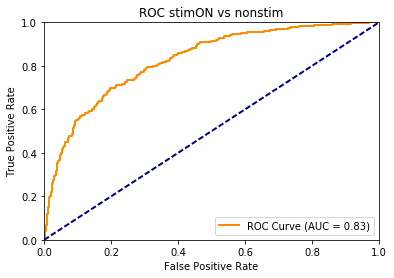

In [10]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC stimON vs nonstim')
plt.legend(loc="lower right")
plt.show()

#plt.figure()
#lw = 2
#plt.plot(fpr2, tpr2, color='darkorange',
#         lw=lw, label='ROC Curve (AUC = %0.2f)' % roc_auc2)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('ROC prestim vs poststim')
#plt.legend(loc="lower right")
#plt.show()

In [11]:
wID=labels['allWindows']['windowID']
y_pred=classifier.predict_proba(X)

In [12]:
print(X.shape)
print(y_pred.shape)
print(len(wID))

(5008, 600)
(5008, 2)
5008


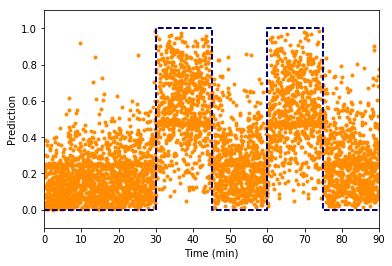

In [13]:
plt.figure()
lw = 2
plt.plot((wID*np.ones((1,len(wID)))/6).T, y_pred[:,1], color='darkorange',
         lw=lw, linestyle=' ', marker='.')
plt.plot([0, 30, 30, 45, 45, 60, 60, 75, 75, 90],
         [0, 0, 1, 1, 0, 0, 1, 1, 0, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0, 90])
plt.ylim([-0.1, 1.1])
plt.xlabel('Time (min)')
plt.ylabel('Prediction')
plt.show()

In [14]:
y_neg, y_pos=np.zeros((9,540)), np.zeros((9,540))
for k in np.arange(0,len(labels['allWindows']['subject'])):
    d=int(labels['allWindows']['subject'][k][6])-1
    w=labels['allWindows']['windowID'][k]-1
    if w<540: 
        y_neg[d,w]=y_pred[k,0]
        y_pos[d,w]=y_pred[k,1]
t = np.arange(0,540)
N = 5
wd = np.arange(0,540-N+1)+(N-2)
for d in range(0,9):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(y_neg[d,], 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    y_neg[d,wd]=moving_aves
    cumsum, moving_aves = [0], []
    for i, x in enumerate(y_pos[d,], 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    y_pos[d,wd]=moving_aves    

In [15]:
meanN=np.mean(y_neg,axis=0)
meanP=np.mean(y_pos,axis=0)

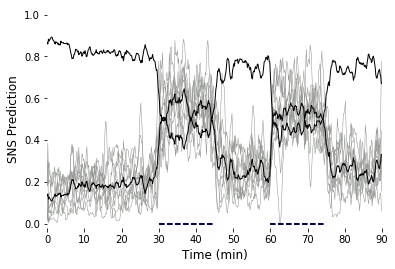

In [16]:
s1, ax=plt.subplots(1,1)
fntsz='large'
for i in range(0,9):
    plt.plot(t/6, y_pos[i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
plt.plot(t/6, meanP, color='black',lw=1, linestyle='-')
plt.plot(t/6, meanN, color='black',lw=1, linestyle='-')
plt.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
plt.plot([60, 75], [0, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0, 90])
plt.ylim([-0.02, 1.02])
plt.xlabel('Time (min)',fontsize=fntsz)
plt.ylabel('SNS Prediction',fontsize=fntsz)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()
s1.savefig('standard_d1-9.jpg')


In [17]:
with open('data/pyData/notch14Data_L.json') as f:
    dataL= json.load(f)
L_labels = dataL[1]
pxxL=np.array(dataL[0])
pxxL = np.log(pxxL)

# reshape nd array to matrix
a, b, c = pxxL.shape
XL = pxxL.reshape(a*b, c).T

L_pred=classifier.predict_proba(XL)

In [18]:
L_neg, L_pos=np.zeros((2,3,360)), np.zeros((2,3,360))
for k in np.arange(0,len(L_labels['allWindows']['subject'])):
    SNS=int('lS' in L_labels['allWindows']['subject'][k])
    d=int(L_labels['allWindows']['subject'][k][6])-1
    w=L_labels['allWindows']['windowID'][k]-1
    if w<360:
        L_neg[SNS,d,w]=L_pred[k,0]
        L_pos[SNS,d,w]=L_pred[k,1]
t = np.arange(0,360)
wd = np.arange(0,360-N+1)+(N-2)
for s in range(0,2):
    for d in range(0,3):
        cumsum, moving_aves = [0], []
        for i, x in enumerate(L_neg[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        L_neg[s,d,wd]=moving_aves
        cumsum, moving_aves = [0], []
        for i, x in enumerate(L_pos[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        L_pos[s,d,wd]=moving_aves    
meanLN, meanLP = np.mean(L_neg,axis=1), np.mean(L_pos,axis=1)

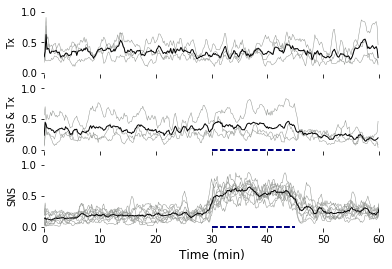

In [19]:
s2, (ax1, ax2, ax3) =plt.subplots(3,1,sharex=True,sharey=True)
fntsz='large'

t = np.arange(0,360)
for i in range(0,3):
    ax1.plot(t/6, L_pos[0,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax1.plot(t/6, meanLP[0,], color='black',lw=1, linestyle='-')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])
plt.xlabel('Time (min)',fontsize=fntsz)
plt.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel('Tx')

for i in range(0,3):
    ax2.plot(t/6, L_pos[1,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax2.plot(t/6, meanLP[1,], color='black',lw=1, linestyle='-')
ax2.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylabel('SNS & Tx')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])


t = np.arange(0,540)
for i in range(0,9):
    ax3.plot(t/6, y_pos[i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax3.plot(t/6, meanP, color='black',lw=1, linestyle='-')
ax3.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('SNS')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])

plt.show()
s2.savefig('Lidocaine.jpg')

In [35]:
print(L_pos.shape, meanLP.shape, y_pos.shape, meanP.shape)

svdata = np.zeros((22, 360))
svdata[range(0, 3), :] = L_pos[0, :, :]
svdata[range(4, 7), :] = L_pos[1, :, :]
svdata[range(8, 10), :] = meanLP
svdata[range(11, 20), :] = y_pos[:, range(0, 360)]
svdata[21, :] = meanP[range(0, 360)]

np.savetxt("lidoRate.csv", svdata.T, delimiter=",")

(2, 3, 360) (2, 360) (9, 540) (540,)


In [20]:
with open('data/pyData/notch14Data_C.json') as f:
    dataC= json.load(f)
C_labels = dataC[1]
pxxC=np.array(dataC[0])
pxxC = np.log(pxxC)

# reshape nd array to matrix
a, b, c = pxxC.shape
XC = pxxC.reshape(a*b, c).T

C_pred=classifier.predict_proba(XC)

In [21]:
C_neg, C_pos=np.zeros((2,3,360)), np.zeros((2,3,360))
for k in np.arange(0,len(C_labels['allWindows']['subject'])):
    HM=int('hm' in C_labels['allWindows']['subject'][k])
    d=int(C_labels['allWindows']['subject'][k][6])-1
    w=C_labels['allWindows']['windowID'][k]-1
    if w<360:
        C_neg[HM,d,w]=C_pred[k,0]
        C_pos[HM,d,w]=C_pred[k,1]
t = np.arange(0,360)
wd = np.arange(0,360-N+1)+(N-2)
for s in range(0,2):
    for d in range(0,3):
        cumsum, moving_aves = [0], []
        for i, x in enumerate(C_neg[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        C_neg[s,d,wd]=moving_aves
        cumsum, moving_aves = [0], []
        for i, x in enumerate(C_pos[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        C_pos[s,d,wd]=moving_aves    
meanCN, meanCP = np.mean(C_neg,axis=1), np.mean(C_pos,axis=1)

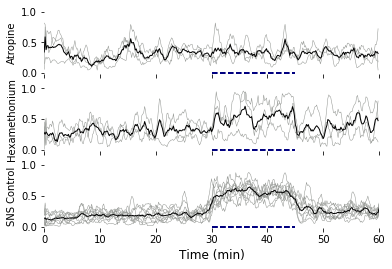

In [22]:
s3, (ax1, ax2, ax3) =plt.subplots(3,1,sharex=True,sharey=True)
fntsz='large'

t = np.arange(0,360)
for i in range(0,3):
    ax1.plot(t/6, C_pos[0,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax1.plot(t/6, meanCP[0,], color='black',lw=1, linestyle='-')
ax1.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])
plt.xlabel('Time (min)',fontsize=fntsz)
plt.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel('Atropine')

for i in range(0,3):
    ax2.plot(t/6, C_pos[1,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax2.plot(t/6, meanCP[1,], color='black',lw=1, linestyle='-')
ax2.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylabel('Hexamethonium')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])


t = np.arange(0,540)
for i in range(0,9):
    ax3.plot(t/6, y_pos[i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax3.plot(t/6, meanP, color='black',lw=1, linestyle='-')
ax3.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('SNS Control')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])

plt.show()
s3.savefig('CholinergicBlockers.jpg')

In [23]:
with open('data/pyData/notch14Data_S.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
labels = data[1]
a, b, c = pxx.shape
X = pxx.reshape(a*b, c).T

AChR_id=[]
AChR_label=[]
for k in np.arange(0,len(C_labels['allWindows']['subject'])):
    if int('hm' in C_labels['allWindows']['subject'][k]) or ((int('ae' in C_labels['allWindows']['subject'][k]) 
                                                              and (C_labels['allWindows']['stimOn'][k]==0))):
        AChR_id.append(k)
        AChR_label.append(0)
    elif (int('ae' in C_labels['allWindows']['subject'][k]) and C_labels['allWindows']['stimOn'][k]):
        AChR_id.append(k)
        AChR_label.append(1)
        
sAChR_id=[]
for k in np.arange(0,len(labels['allWindows']['subject'])):
    if labels['allWindows']['stimOn'][k]:
        sAChR_id.append(k)
        AChR_label.append(1)
    elif labels['allWindows']['baseline'][k] or labels['allWindows']['stimOff']:
        sAChR_id.append(k)
        AChR_label.append(0)
#for k in range(540,940):
#    if labels['allWindows']['stimOn'][k]:
#        sAChR_id.append(k)
#        AChR_label.append(1)
#    elif labels['allWindows']['baseline'][k]:
#        sAChR_id.append(k)
#        AChR_label.append(0)
#for k in range(1120,1480):
#    if labels['allWindows']['stimOn'][k]:
#        sAChR_id.append(k)
#        AChR_label.append(1)
#    elif labels['allWindows']['baseline'][k]:
#        sAChR_id.append(k)
#        AChR_label.append(0)

lAChR_id=[]
for k in np.arange(0,len(L_labels['allWindows']['subject'])):
    if (int('lS' in L_labels['allWindows']['subject'][k]) and L_labels['allWindows']['stimOn'][k]):
        lAChR_id.append(k)
        AChR_label.append(0)

AChR_X=np.concatenate((XC[AChR_id],X[sAChR_id],XL[lAChR_id]), axis=0)

In [24]:
from sklearn.model_selection import train_test_split

AChxTrain, AChxTest, AChyTrain, AChyTest = train_test_split(AChR_X, np.array(AChR_label), test_size=0.3, random_state=1423)

from sklearn.decomposition import FastICA

C = 20;

# Compute ICA
ACh_ica = FastICA(n_components=C, max_iter=5000,tol=0.001)
AChscoresTrain = ACh_ica.fit_transform(AChxTrain)  # Reconstruct signals

AChfactors = ACh_ica.mixing_  # Get estimated mixing matrix
a, b, c = pxx.shape
AChfactors = AChfactors.reshape(a, b, C)

from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

ACh_classifier = svm.SVC(kernel='linear', probability=True, class_weight='balanced')
ACh_classifier.fit(AChscoresTrain, AChyTrain)
ACh_trainAcc = ACh_classifier.score(AChscoresTrain, AChyTrain)

AChscoresTest = ACh_ica.transform(AChxTest)
ACh_testAcc = ACh_classifier.score(AChscoresTest, AChyTest)
print(ACh_testAcc, ACh_trainAcc)

ACh_classifier.fit(AChxTrain, AChyTrain)
print('done')

0.688363798484 0.688587268209
done


In [25]:
wID=labels['allWindows']['windowID']
AChy_pred=ACh_classifier.predict_proba(X)

AChy_neg, AChy_pos=np.zeros((9,540)), np.zeros((9,540))
for k in np.arange(0,len(labels['allWindows']['subject'])):
    d=int(labels['allWindows']['subject'][k][6])-1
    w=labels['allWindows']['windowID'][k]-1
    if w<540: 
        AChy_neg[d,w]=AChy_pred[k,0]
        AChy_pos[d,w]=AChy_pred[k,1]
t = np.arange(0,540)
N = 5
wd = np.arange(0,540-N+1)+(N-2)
for d in range(0,9):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(AChy_neg[d,], 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    AChy_neg[d,wd]=moving_aves
    cumsum, moving_aves = [0], []
    for i, x in enumerate(AChy_pos[d,], 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    AChy_pos[d,wd]=moving_aves  
ACh_meanN=np.mean(AChy_neg,axis=0)
ACh_meanP=np.mean(AChy_pos,axis=0)

In [26]:
AChC_pred=ACh_classifier.predict_proba(XC)
AChC_neg, AChC_pos=np.zeros((2,3,360)), np.zeros((2,3,360))
for k in np.arange(0,len(C_labels['allWindows']['subject'])):
    HM=int('hm' in C_labels['allWindows']['subject'][k])
    d=int(C_labels['allWindows']['subject'][k][6])-1
    w=C_labels['allWindows']['windowID'][k]-1
    if w<360:
        AChC_neg[HM,d,w]=AChC_pred[k,0]
        AChC_pos[HM,d,w]=AChC_pred[k,1]
t = np.arange(0,360)
wd = np.arange(0,360-N+1)+(N-2)
for s in range(0,2):
    for d in range(0,3):
        cumsum, moving_aves = [0], []
        for i, x in enumerate(AChC_neg[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        AChC_neg[s,d,wd]=moving_aves
        cumsum, moving_aves = [0], []
        for i, x in enumerate(AChC_pos[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        AChC_pos[s,d,wd]=moving_aves    
ACh_meanCN, ACh_meanCP = np.mean(AChC_neg,axis=1), np.mean(AChC_pos,axis=1)

AChL_pred=ACh_classifier.predict_proba(XL)
AChL_neg, AChL_pos=np.zeros((2,3,360)), np.zeros((2,3,360))
for k in np.arange(0,len(L_labels['allWindows']['subject'])):
    SNS=int('lS' in L_labels['allWindows']['subject'][k])
    d=int(L_labels['allWindows']['subject'][k][6])-1
    w=L_labels['allWindows']['windowID'][k]-1
    if w<360:
        AChL_neg[SNS,d,w]=AChL_pred[k,0]
        AChL_pos[SNS,d,w]=AChL_pred[k,1]
t = np.arange(0,360)
wd = np.arange(0,360-N+1)+(N-2)
for s in range(0,2):
    for d in range(0,3):
        cumsum, moving_aves = [0], []
        for i, x in enumerate(AChL_neg[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        AChL_neg[s,d,wd]=moving_aves
        cumsum, moving_aves = [0], []
        for i, x in enumerate(AChL_pos[s,d,], 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        AChL_pos[s,d,wd]=moving_aves    
ACh_meanLN, ACh_meanLP = np.mean(AChL_neg,axis=1), np.mean(AChL_pos,axis=1)

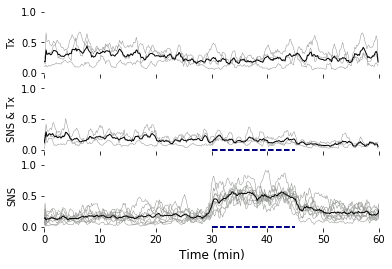

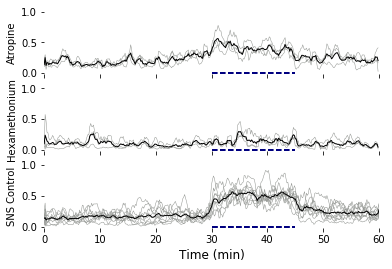

In [27]:
s4, (ax1, ax2, ax3) =plt.subplots(3,1,sharex=True,sharey=True)
fntsz='large'

t = np.arange(0,360)
for i in range(0,3):
    ax1.plot(t/6, AChL_pos[0,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax1.plot(t/6, ACh_meanLP[0,], color='black',lw=1, linestyle='-')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])
plt.xlabel('Time (min)',fontsize=fntsz)
plt.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel('Tx')

for i in range(0,3):
    ax2.plot(t/6, AChL_pos[1,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax2.plot(t/6, ACh_meanLP[1,], color='black',lw=1, linestyle='-')
ax2.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylabel('SNS & Tx')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])

t = np.arange(0,540)
for i in range(0,9):
    ax3.plot(t/6, AChy_pos[i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax3.plot(t/6, ACh_meanP, color='black',lw=1, linestyle='-')
ax3.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('SNS')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])

s5, (ax1, ax2, ax3) =plt.subplots(3,1,sharex=True,sharey=True)
fntsz='large'

t = np.arange(0,360)
for i in range(0,3):
    ax1.plot(t/6, AChC_pos[0,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax1.plot(t/6, ACh_meanCP[0,], color='black',lw=1, linestyle='-')
ax1.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])
plt.xlabel('Time (min)',fontsize=fntsz)
plt.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel('Atropine')

for i in range(0,3):
    ax2.plot(t/6, AChC_pos[1,i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax2.plot(t/6, ACh_meanCP[1,], color='black',lw=1, linestyle='-')
ax2.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylabel('Hexamethonium')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])


t = np.arange(0,540)
for i in range(0,9):
    ax3.plot(t/6, AChy_pos[i,], color='xkcd:grey',
         lw=0.5, linestyle='-')
ax3.plot(t/6, ACh_meanP, color='black',lw=1, linestyle='-')
ax3.plot([30, 45], [0, 0], color='navy', lw=lw, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('SNS Control')
plt.xlim([0, 60])
plt.ylim([-0.02, 1.02])

plt.show()